In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import torch

sns.set_palette('deep')
random_state = 1

# 2. Loading the Data <a class="anchor" id="loading-data"></a>

In [2]:
_train = pd.read_csv("../input/train.csv")
_test = pd.read_csv("../input/test.csv")

# Make a copy to be modified
train = _train.copy()
test = _test.copy()

In [3]:
train_len = len(train)
print("Training dataset size = {}".format(train_len))
train.head()

Training dataset size = 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_len = len(test)
print("Test dataset size = {}".format(test_len))
test.head()

Test dataset size = 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 3. Data Analysis <a class="anchor" id="data-analysis"></a>

Like most kernels, we will start by analyzing the features from the dataset, one-by-one, focusing on:
- Finding correlations, not only between each feature and survival but also between the features themselves to understand if the information the feature provides is not redundant.
- Creating visualizations that help us understand the data.
- Cleaning the dataset by removing redundant features.
- Filling missing data when needed.
- Converting data types when advantageous (e.g. converting categorical data to numerical).

In [5]:
# Remove PassengerId since it's not a feature
train.drop(columns='PassengerId', inplace=True)
test.drop(columns='PassengerId', inplace=True)

## 3.1 Missing data <a class="anchor" id="missing-data"></a>

In [6]:
# Concatenate the train and test datasets. Survived is not a feature so we drop it
dataset = pd.concat([train, test], sort=False).drop(columns='Survived')
pd.DataFrame({'No. NaN': dataset.isna().sum(), '%': dataset.isna().sum() / len(dataset)})

,%,No. NaN
Pclass,0.000000,0
Name,0.000000,0
Sex,0.000000,0
Age,0.200917,263
SibSp,0.000000,0
Parch,0.000000,0
Ticket,0.000000,0
Fare,0.000764,1
Cabin,0.774637,1014
Embarked,0.001528,2


Features with missing data:
- **Cabin (~77%)**: Drop it. Too much data is missing to fill without introducing a significant amount of noise.
- **Age (~20%)**: A significant amount of data is missing, but if it's useful we can try to fill it.
- **Fare (1 data point)**: Since only one value is missing we can fill it with something simple like a median.
- **Embarked (2 data points)**: Since only two values are missing we can fill them with something simple like a median.

In [7]:
train.drop(columns='Cabin', inplace=True)
test.drop(columns='Cabin', inplace=True)

## 3.2 Age <a class="anchor" id="age"></a>

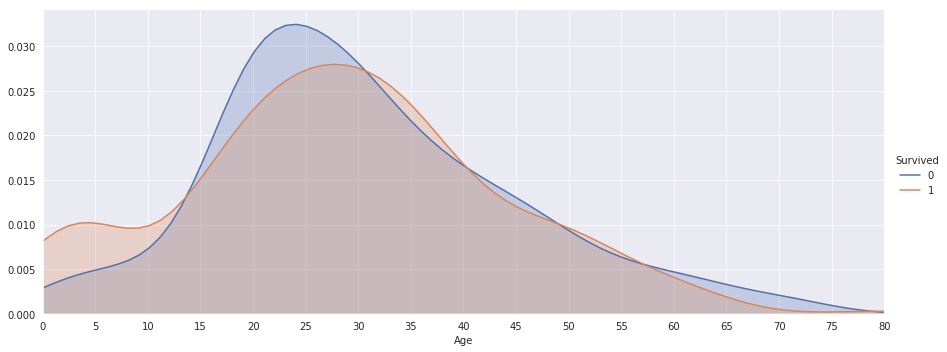

In [8]:
with sns.axes_style("darkgrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=2.5)
    g.map(sns.kdeplot, 'Age', shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Age'].max() + 1, 5), xlim=(0, train['Age'].max()))

Some observations:

- Children (age < 5) have much higher chances of survival than any other age group
- Passengers between the ages of 13 to 30 are more likely to die than to survive
- From 30 to 60 the survival rate is close to 50%
- Passengers older than 60 are more likely to die than to survive

`Age` can give us some important information, particularly for children and younger adults where there is clearly a trend.

Keeping the previous observations in mind we'll split `Age` in 4 bins/clusters. I have found that `KMeans` works better than the more frequentely used `pandas.cut` or `pandas.qcut`. It doesn't play a big role in the final score but is particularly important when filling the missing age values.

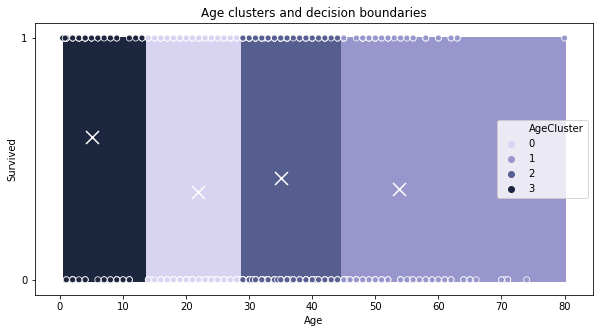

In [9]:
# Use KMeans to cluster `Age`
num_clusters = 4
X = train[[ 'Age', 'Survived']].dropna()
kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
kmeans.fit(X)
X['AgeCluster'] = kmeans.labels_

# Plot the decision boundary
# See http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
plt.figure(figsize=(10,5))
h = 0.01
x_min, x_max = X['Age'].min() - h, X['Age'].max() + h
y_min, y_max = X['Survived'].min() - h, X['Survived'].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the age cluster for each point in a mesh
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
cmap = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=cmap, aspect='auto')

# Plot the ages
sns.scatterplot(x='Age', y='Survived', hue='AgeCluster', data=X, palette=cmap)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w')
plt.yticks([0, 1])
plt.title("Age clusters and decision boundaries")
plt.show()

Now that we have the clusters we have to convert them into age ranges and feed those ranges to `pandas.cut` to cut both the training and test datasets.

In [10]:
# Convert K-means clusters to age bands
age_bands = []
for k in range(num_clusters):
    age_bands.append(xx[Z==k].min())

# Since the clusters are not sorted we sort the intervals
age_bands.sort()

# Set the lower bound of the first interval to 0
age_bands[0] = 0

# Set the higher bound of the last interval to infinite just in case there are older older passengers in the test set
age_bands.append(np.inf)

# Convert list to numpy array
print("Age bands: {}".format(np.array(age_bands)))

Age bands: [ 0.   13.47 28.52 44.4    inf]


In [11]:
# Use both the training and test dataset to fill the missing Age values
dataset = pd.concat([train, test], sort=True)
dataset['AgeBand'] = pd.cut(dataset['Age'], age_bands)

dataset.groupby('AgeBand')['Survived'].mean()

AgeBand
(0.0, 13.47]      0.591549
(13.47, 28.52]    0.361775
(28.52, 44.4]     0.421277
(44.4, inf]       0.373913
Name: Survived, dtype: float64

### 3.2.1 Filing missing Age values <a class="anchor" id="fill-age"></a>

To fill the missing 20% age values, we are going to estimate the age band using the most accurate of the following classifiers:
- Logistic regression
- K-nearest neighbors
- Decision tree

with the following features:
- Age
- Pclass
- SibSp
- Parch
- Sex
- Title (engineered from Name)

There are many ways to fill the missing ages, I chose this one because it was an excuse to do more some stuff with machine learning models and it worked well enough.

#### Feature selection
Start by getting the title of each passenger using `Name`.

In [12]:
# Use both the training and test dataset to fill the missing Age values
fill_age_df = dataset[['Name', 'AgeBand', 'Pclass', 'SibSp', 'Parch', 'Sex']].copy()

# Get the titles of the passengers
fill_age_df['Title'] = fill_age_df['Name'].apply(lambda x: x[x.find(', ') + 2:x.find('.')])

pd.crosstab(fill_age_df['Title'], fill_age_df['Sex']).transpose()

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


Most passengers have one of four titles:
- Master
- Miss
- Mr
- Mrs

We can join `Mlle` with `Miss` since they both typically refer to an unmarried female; `Mme` with `Mrs` since they both typically refer to a married female; and, `Ms` and `Miss`, `Ms` is a more generic title that can either refer to `Miss` or `Mrs` but given that `Miss` is more frequent we'll go with that.

For the remaining titles, we are going to gather them all in a title named `Rare` to convey that these passengers have a unique social status.

Finally, `Title` is converted to dummies.

In [13]:
# Join Mlle (Mademoiselle) and Ms with Miss - Mlle and Miss both indicate a unmarried status while Ms is more generic
# it can mean both Miss and Mrs, I chose Miss because it's more frequent
fill_age_df['Title'].replace(to_replace=['Mlle', 'Ms'], value='Miss', inplace=True)

# Join Mme (Madame) with Mrs - Mme and Mrs both indicate a married status
fill_age_df['Title'].replace(to_replace='Mme', value='Mrs', inplace=True)

# Join the remaining titles with low frequencies
fill_age_df['Title'].replace(to_replace=['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir',
                                         'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                             value='Rare', inplace=True)

title_dummies = pd.get_dummies(fill_age_df['Title'], drop_first=True)
fill_age_df = pd.concat([fill_age_df, title_dummies], axis=1)
fill_age_df.head(2)

,Name,AgeBand,Pclass,SibSp,Parch,Sex,Title,Miss,Mr,Mrs,Rare
0,"Braund, Mr. Owen Harris","(13.47, 28.52]",3,1,0,male,Mr,0,1,0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...","(28.52, 44.4]",1,1,0,female,Mrs,0,0,1,0


Also, convert `Sex` to a dummy (`IsMale`) and encode `AgeBand` in integers.

In [14]:
# Encode ages and sex
fill_age_df['IsMale'] = fill_age_df['Sex'].astype('category').cat.codes
fill_age_df['AgeBand'] = fill_age_df['AgeBand'].astype('category').cat.codes

# Drop columns we no longer need
fill_age_df.drop(columns=['Name', 'Sex', 'Title'], inplace=True)

fill_age_df.head(2)

,AgeBand,Pclass,SibSp,Parch,Miss,Mr,Mrs,Rare,IsMale
0,1,3,1,0,0,1,0,0,1
1,2,1,1,0,0,0,1,0,0


The dataset for age prediction is almost done, the last step is to split it into training samples, training labels, and testing samples.

In [15]:
# Drop all rows with unknown age bands (-1) from the training set
X_train = fill_age_df.loc[fill_age_df['AgeBand'] != -1].drop(columns='AgeBand')
Y_train = fill_age_df['AgeBand'].loc[fill_age_df['AgeBand'] != -1]

# Get all rows with unknown age bands (-1) for the test set
X = fill_age_df.loc[fill_age_df['AgeBand'] == -1].drop(columns='AgeBand')

# Some shapes to double-check
print("Training samples shape: {}".format(X_train.shape))
print("Training labels shape: {}".format(Y_train.shape))
print("Samples to predict shape: {}".format(X.shape))

Training samples shape: (1046, 8)
Training labels shape: (1046,)
Samples to predict shape: (263, 8)


#### Age band modeling

Time to fill the missing age values!

As stated previously, we are going to create three simple classifier models and use cross-validation to analyze which one is better.

In [16]:
logreg = LogisticRegression(random_state=random_state)
logreg_scores = cross_val_score(logreg, X_train, Y_train, cv=10)
print("Logistic Regression cross-validation scores: {:.3f}".format(logreg_scores.mean()))

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, Y_train, cv=10)
print("KNeighbors cross-validation scores: {:.3f}".format(knn_scores.mean()))

tree = DecisionTreeClassifier(random_state=random_state)
tree_scores = cross_val_score(tree, X_train, Y_train, cv=10)
print("Tree Classifier cross-validation scores: {:.3f}".format(tree_scores.mean()))

Logistic Regression cross-validation scores: 0.536
KNeighbors cross-validation scores: 0.517
Tree Classifier cross-validation scores: 0.561


Overall, none of the models achieves high-accuracy; however, if we check the per-class/per-age band accuracy, we see that our best model (`DecisionTreeClassifier`) is really good at predicting children (95.7% accuracy for passengers between the ages of 0 and 13.47) and young adults (84.5% accuracy for passengers between the ages of 13.47 and 28.52). As discussed previously, these are the most relevant age bands; therefore, a low overall accuracy shouldn't be a big issue as long as we have high accuracy in these age bands.

In [17]:
# Make predictions using our best model (Decision Tree)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_train)

# Compute the per-class/per-age band accuracy
total = np.bincount(Y_train.values, minlength=4)
correct = np.bincount(Y_pred[Y_pred == Y_train.values], minlength=4)
class_acc = correct / total
pd.DataFrame({'AgeBand': np.arange(4),
              'AgeInterval': dataset['AgeBand'].cat.categories,
              'PerClassAcc.': class_acc})

,AgeBand,AgeInterval,PerClassAcc.
0,0,"(0.0, 13.47]",0.959596
1,1,"(13.47, 28.52]",0.845455
2,2,"(28.52, 44.4]",0.320242
3,3,"(44.4, inf]",0.488636


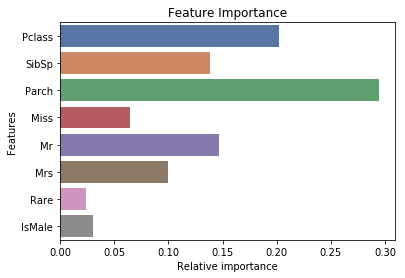

In [18]:
# Feature importance
g = sns.barplot(x=tree.feature_importances_, y=X.columns, orient='h')
_ = g.set_xlabel('Relative importance')
_ = g.set_ylabel('Features')
_ = g.set_title('Feature Importance')

We can now predict the age band for passengers with missing data:

In [19]:
Y = tree.predict(X)
fill_age_df.loc[fill_age_df['AgeBand'] == -1, 'AgeBand'] = Y

Apply the integer encoded age bands to the train and test datasets.

In [20]:
train['AgeBand'] = fill_age_df.iloc[:train_len, 0]
test['AgeBand'] = fill_age_df.iloc[train_len:, 0]

# Remove Age column
train.drop(columns='Age', inplace=True)
test.drop(columns='Age', inplace=True)

train.head(2)

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,AgeBand
0,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,2


## 3.3 Sex <a class="anchor" id="sex"></a>

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

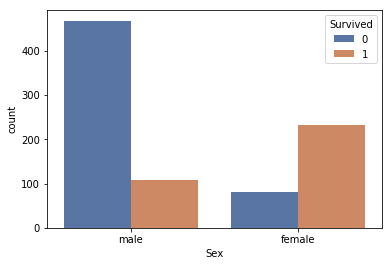

In [21]:
_ = sns.countplot(x='Sex', hue='Survived', data=train)
train.groupby('Sex')['Survived'].mean()

Females have much higher survival rates as expected, all we have to do is one-hot encode `Sex` so all machine learning algorithms can handle it.

In [22]:
# One-encode using dummies
train['IsMale'] = pd.get_dummies(train['Sex'], drop_first=True)
test['IsMale'] = pd.get_dummies(test['Sex'], drop_first=True)

# Drop the Sex column
train.drop(columns='Sex', inplace=True)
test.drop(columns='Sex', inplace=True)

## 3.4 Ticket class (Pclass) <a class="anchor" id="pclass"></a>

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

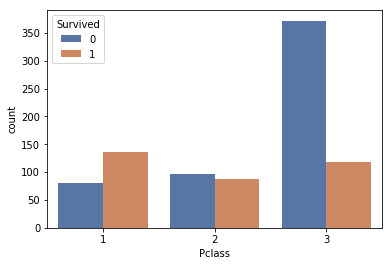

In [23]:
_ = sns.countplot(x='Pclass', hue='Survived', data=train)
train.groupby('Pclass')['Survived'].mean()

Passengers with higher ticket class (lower `Pclass`) have higher chances of survival:
- 1st class: 63%
- 2nd class: 48%
- 3rd class: 24%

Keep the feature as-is, `Pclass` is already encoded in integers (one-hot encoding would leave out the natural order of ticket class which is an important element of the feature).

## 3.5 Port of Embarkation (Embarked) <a class="anchor" id="embarked"></a>

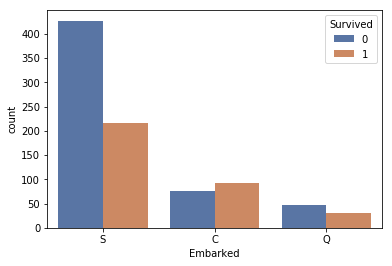

In [24]:
_ = sns.countplot(x='Embarked', hue='Survived', data=train)

After looking at this chart my first thought was that it was a useful feature, we can see that passengers from different ports have varying chances of survival. But it intuitively, it doesn't really make sense, why would the port make any difference on whether someone survives or not? I think that what this chart shows is just the combination of `IsMale` and `Pclass`, see the next chart and table.

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


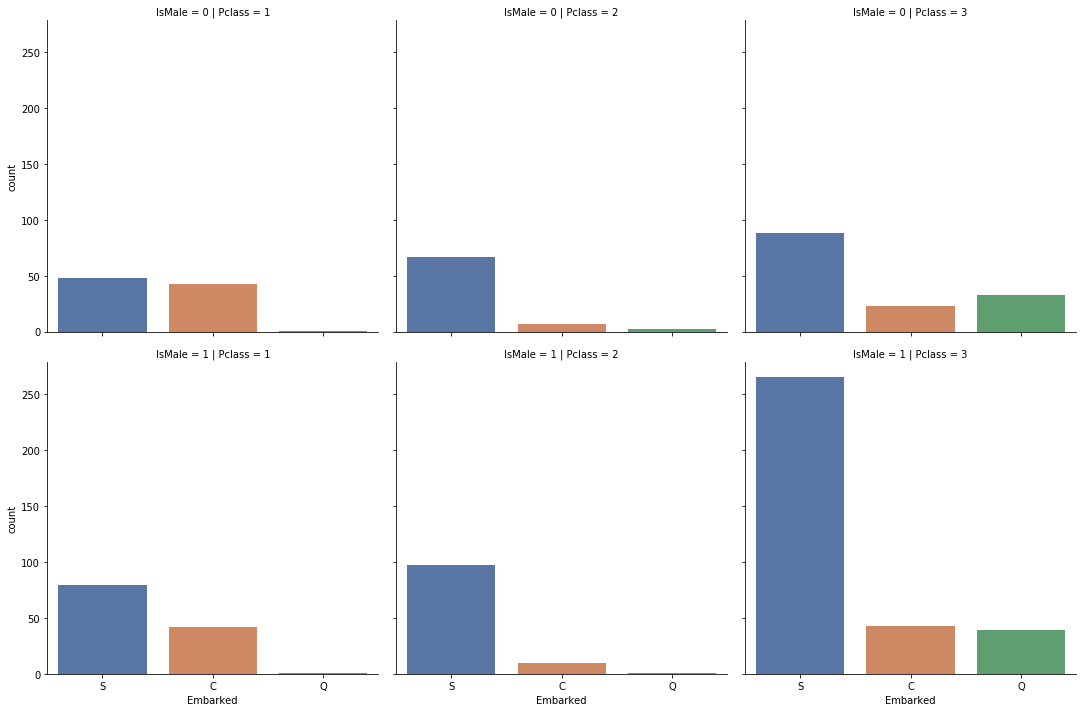

In [25]:
# Plot relationship between Embarked, Pclass, and IsMale
_ = sns.factorplot(x='Embarked', col='Pclass', row='IsMale', data=train, kind='count')

In [26]:
# Passengers grouped by Embarked, Pclass, and IsMale
embarked_corr = (train[['Survived', 'Embarked', 'Pclass', 'IsMale']].groupby(['Embarked', 'Pclass', 'IsMale'])                                            
                                                                    .agg(['count', 'sum', 'mean']))
embarked_corr.columns = embarked_corr.columns.droplevel(0)
embarked_corr.columns = ['Total', 'Survived', 'Rate']
embarked_corr

Total  Survived      Rate
Embarked Pclass IsMale                           
C        1      0          43        42  0.976744
                1          42        17  0.404762
         2      0           7         7  1.000000
                1          10         2  0.200000
         3      0          23        15  0.652174
                1          43        10  0.232558
Q        1      0           1         1  1.000000
                1           1         0  0.000000
         2      0           2         2  1.000000
                1           1         0  0.000000
         3      0          33        24  0.727273
                1          39         3  0.076923
S        1      0          48        46  0.958333
                1          79        28  0.354430
         2      0          67        61  0.910448
                1          97        15  0.154639
         3      0          88        33  0.375000
                1         265        34  0.128302

We see that in `Southampton (S)` a high number of 3rd class males embarked on the Titanic, so a low survival rate is to be expected. A high number of 1st class passengers embarked in `Cherbourg (C)`, so we see a high survival rate. In `Queenstown (Q)`, however, the chart shows something that I was not expecting given the following observations:
- the vast majority of passengers are 3rd class passengers;
- the number of males and females is comparable.

Given these conditions, the survival rate should be correlated only to `IsMale`, and that is true for females; males however end-up with half the survival rate. Though this is a sample of 42 males in a population of 577, it's not enough to convince me that `Embarked` is independently correlated with survival.

In [27]:
train.drop(columns='Embarked', inplace=True)
test.drop(columns='Embarked', inplace=True)

## 3.6 Fare <a class="anchor" id="fare"></a>
Despite the fact that the [Titanic: Machine Learning from Disaster data page](https://www.kaggle.com/c/titanic/data) states that `Fare` is the passenger fare, I'm fairly sure that it's actually the ticket fare. Therefore, we will divide `Fare` by the ticket frequency (`TicketFreq`) to compute the actual passenger fare (`PassengerFare`).

In [28]:
dataset = pd.concat([train, test], sort=True)
dataset['TicketFreq'] = dataset.groupby('Ticket')['Ticket'].transform('count')
dataset['PassengerFare'] = dataset['Fare'] / dataset['TicketFreq']

train.head(2)

,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,AgeBand,IsMale
0,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,2,0


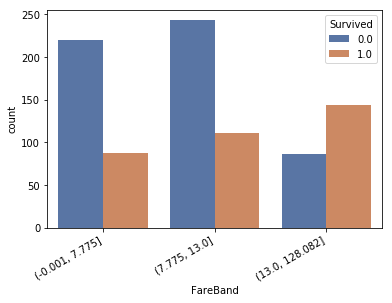

In [29]:
num_fare_bins = 3
dataset['FareBand'], fare_bins = pd.qcut(dataset['PassengerFare'], num_fare_bins, retbins=True)
_ = sns.countplot(x='FareBand', hue='Survived', data=dataset)
_ = plt.xticks(rotation=30, ha='right')

We see that as `Fare` increases, the survival rate also increases, awesome...well, it's also likely that this feature is highly related to `Pclass`, lower `Pclass` should translate to higher `PassengerFare`. 

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


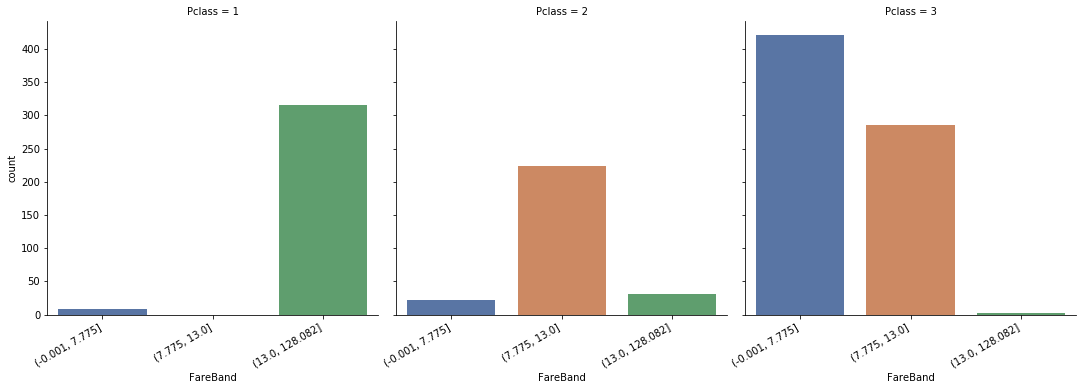

In [30]:
# Plot relationship between FareBand and Pclass
g = sns.factorplot(x='FareBand', col='Pclass', data=dataset, kind='count')
_ = g.set_xticklabels(rotation=30, ha='right')

`FareBand` describes `Pclass` 1 and 2 almost perfectly. But why are there so many passengers with `Pclass = 3` tickets with fares expected for `Pclass = 2`? Let's compare the mean passenger fare and survival for passengers in 2nd and 3rd class in the same fare range (`(7.775, 13.0]`).

In [31]:
band = pd.Interval(left=7.775, right=13.0)
mask = (dataset['FareBand'] == band) & (dataset['Pclass'] != 1)

dataset.loc[mask, ['FareBand', 'Pclass', 'PassengerFare']].groupby(['FareBand', 'Pclass']).agg(['mean'])

PassengerFare
                              mean
FareBand      Pclass              
(7.775, 13.0] 2          11.648066
              3           8.225494

Despite belonging to the same fare band, 3rd class passengers paid on average less than 2nd class passengers. There is a clear boundary between the two, just not enough to segment them into different bands.  We can also check if there is any correlation between 3rd class passengers that paid higher fares and survival.

In [32]:
band1 = pd.Interval(left=0, right=7.775)
band2 = pd.Interval(left=7.775, right=13.0)
mask = ((dataset['FareBand'] == band1) | (dataset['FareBand'] == band2)) & (dataset['Pclass'] == 3)

dataset.loc[mask, ['FareBand', 'Pclass', 'Survived']].groupby(['FareBand', 'Pclass']).agg(['mean'])

,,Survived
,,mean
FareBand,Pclass,
"(-0.001, 7.775]",3,0.280142
"(7.775, 13.0]",3,0.193237


These results were quite surprising to me. Passengers that overpaid for their tickets shouldn't have substantially different chances of survival; and to make it even more surprising, those that overpaid have lower chances of survival. If we look at the other features and their relationship with these two groups we find something interesting about the distribution of children.

In [33]:
dataset.loc[mask, ['FareBand', 'Pclass', 'AgeBand']].groupby(['FareBand', 'Pclass']).agg(['value_counts']).sort_index()

AgeBand
                               value_counts
FareBand        Pclass AgeBand             
(-0.001, 7.775] 3      0                 83
                       1                239
                       2                 79
                       3                 20
(7.775, 13.0]   3      0                  2
                       1                205
                       2                 71
                       3                  7

There are 83 children (`AgeBand = 0`) with 3rd class ticket  in `FareBand = (-0.001, 7.775]` and only 2 in `FareBand = (7.775, 13.0]`. Given that children have ~60% survival rate, the lack of them in `FareBand = (7.775, 13.0]` compared to `FareBand = (-0.001, 7.775]`  explains the lower survival rate.

We can also explain why some 3rd class passengers seem to have overpaid for their tickets...they didn't, the passengers in `FareBand = (-0.001, 7.775]` paid less because children had a discounted price lowering the passenger fare. and isolating them in `FareBand = (-0.001, 7.775]`.

In conclusion, `Fare` is correlated with the other features, therefore, we'll drop it from our training and test datasets.

In [34]:
train.drop(columns='Fare', inplace=True)
test.drop(columns='Fare', inplace=True)

train.head(2)

,Survived,Pclass,Name,SibSp,Parch,Ticket,AgeBand,IsMale
0,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,2,0


# 4. Engineering Groups of Passengers <a class="anchor" id="engineer"></a>

Many kernels have explored `SibSp` and `Parch` to engineer family related features. However, in recent months the top kernels have found that `SibSp` and `Parch` contain inconsistencies (see the excellent work by [Erik Bruin](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting)) and that looking at groups of passengers travelling together instead of just families yields better results (see [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever), [Titanic \[0.82\] - \[0.83\]](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83), [Titanic using Name only \[0.81818\]](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook), and [Titantic Mega Model - \[0.84210\]
](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210) for some great work using groups of passengers).

With this knowledge we are going to engineer four new features derived from groups of passengers:
- `InGroup`: the passenger is traveling with other passengers or not;
- `InWcg`: the passenger is a member of a woman-child group or not;
- `WcgAllSurvived`: whether the members of the woman-child group all survived;
- `WcgAllDied`: whether the members of the woman-child group all died.

## 4.1 Identifying groups of passengers <a class="anchor" id="identify-groups"></a>

To engineer these features we first have to define what's a group and identify which passengers belong to which group. Based on [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever) and [Titantic Mega Model - \[0.84210\]
](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210) we are going to define a group as a set of passengers that all share at least one of the following conditions:
1. Combination of: surname, PClass, ticket number (excluding the last digit), and embarked;
2. Ticket number.

The first condition will identify mostly families while the second will identify groups of friends that share the same ticket, including passengers travelling with families that are not part of the family.

In [35]:
# Create the new feature for the whole dataset 
# (I am using _train and _test because train and test no longer contain 'Embarked')
dataset = pd.concat([_train, _test], sort=True, ignore_index=True)

### 4.1.1 Identifying groups by surname, Pclass, ticket number (excluding last digit), and embarked (SPTE) <a class="anchor" id="spte"></a>

In [36]:
surname = dataset['Name'].apply(lambda x: x[:x.find(',')])
ticket = dataset['Ticket'].apply(lambda x: x[:-1])

dataset['SPTE'] = (surname.astype(str) + '-' + dataset['Pclass'].astype(str) + '-'
           + ticket.astype(str) + '-' + dataset['Embarked'].astype(str))

spte_count = dataset['SPTE'].value_counts(sort=False)

def spte_group_lebeler(group):
    group_elements = dataset.loc[dataset['SPTE'] == group, 'PassengerId']
    if len(group_elements) == 1:
        return 0
    else:
        return group_elements.min()

dataset['GroupId'] = dataset['SPTE'].apply(spte_group_lebeler)
dataset.drop(columns='SPTE', inplace=True)
dataset.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,GroupId
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,0
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,0
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,0
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,0
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,129



### 4.1.2 Identifying groups by ticket number <a class="anchor" id="ticket"></a>

In [37]:
# Groups that share the same ticket number
def ticket_group_labeler(group):
    unique_groups = group.unique()
    if len(unique_groups) == 1:
        return unique_groups[0]
    elif len(unique_groups) == 2 and min(unique_groups) == 0:
        return dataset.loc[group.index, 'PassengerId'].min()
    else:
        raise ValueError("Found conflict between SPTE and ticket grouping:\n\n{}".format(dataset.loc[group.index]))

dataset['GroupId'] = dataset.groupby('Ticket')['GroupId'].transform(ticket_group_labeler)
dataset.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,GroupId
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,0
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,308
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,0
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,0
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,129


## 4.2 Engineer InGroup <a class="anchor" id="ingroup"></a>

`InGroup` is `1` if the passenger is in a group (`GroupId` is not unique); otherwise is `0`.

InGroup
0    0.315175
1    0.477454
Name: Survived, dtype: float64

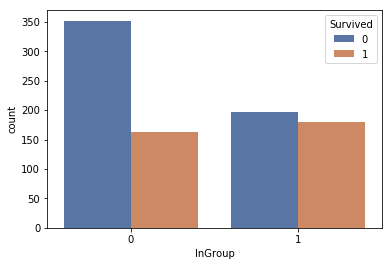

In [38]:
# Calculate the size of each group
dataset['GroupSize'] = dataset.groupby('GroupId')['GroupId'].transform('count')
dataset.loc[dataset['GroupId'] == 0, 'GroupSize'] = 1

# InGroup is 1 for groups with more than one member
dataset['InGroup'] = (dataset['GroupSize'] > 1).astype(int)

# Add to the train and test datasets
train['InGroup'] = dataset.iloc[:train_len, -1]
test['InGroup'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

_ = sns.countplot(x='InGroup', hue='Survived', data=train)
train.groupby('InGroup')['Survived'].mean()

## 4.3 Engineer InWcg <a class="anchor" id="inwcg"></a>

Woman-child-groups are groups of passengers traveling together whose members are either females or boys (males with a `Master` title). Chris Deotte found that members of woman-child-groups are more likely to share the same fate than other groups. He presented the idea in [Titanic using Name only \[0.81818\]](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook) and perfected the definition of these groups in [Titantic Mega Model - \[0.84210\]
](https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210).

`InWcg` is `1` if the passenger is in a woman-child-group; otherwise is `0`.

In [39]:
# Get the titles of the passengers
dataset['Title'] = dataset['Name'].apply(lambda x: x[x.find(', ') + 2:x.find('.')])

# Create a mask to account only for females or boys in groups
mask = (dataset['GroupId'] != 0) & ((dataset['Title'] == 'Master') | (dataset['Sex'] == 'female'))

# Get the number of females and boys in each group, discard groups with only one member
wcg_groups = dataset.loc[mask, 'GroupId'].value_counts()
wcg_groups = wcg_groups[wcg_groups > 1]

# Update the mask to discard groups with only one female or boy
mask = mask & (dataset['GroupId'].isin(wcg_groups.index))

# Create the new feature using the updated mask
dataset['InWcg'] = 0
dataset.loc[mask, 'InWcg'] = 1

print("Number of woman-child-groups found:", len(wcg_groups))
print("Number of passengers in woman-child-groups:", len(dataset.loc[dataset['InWcg'] == 1]))

# Add to the train and test datasets
train['InWcg'] = dataset.iloc[:train_len, -1]
test['InWcg'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

Number of woman-child-groups found: 94
Number of passengers in woman-child-groups: 257


## 4.4 Engineer WcgAllSurvived <a class="anchor" id="wcgallsurvived"></a>

For a given passenger in a woman-child-group, `WcgAllSurvived` is equal to `1` if all members of that group survived; otherwise is `0`. 

Note that passengers from the test set are ignored. `WcgAllSurvived` is based on the training set data only.

In [40]:
dataset['WcgAllSurvived'] = dataset.loc[dataset['InWcg'] == 1].groupby('GroupId')['Survived'].transform(np.nanmean)

# `np.nanmean` returns NaN for groups without survival information (test set only groups)
# Replace the NaN with 0
dataset.loc[dataset['WcgAllSurvived'].isna(), 'WcgAllSurvived'] = 0
dataset['WcgAllSurvived'] = dataset['WcgAllSurvived'].astype(int)

# Add to the train and test datasets
train['WcgAllSurvived'] = dataset.iloc[:train_len, -1]
test['WcgAllSurvived'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/pandas/core/groupby/groupby.py:3652: RuntimeWarning: Mean of empty slice
  wrapper = lambda x: func(x, *args, **kwargs)


## 4.5 Engineer WcgAllDied <a class="anchor" id="wcgalldied"></a>

`WcgAllDied` is just the opposite of `WcgAllSurvived`. For a given passenger in a woman-child-group, `WcgAllDied` is equal to `1` if all members of that group died; otherwise is `0`. 

In [41]:
dataset['WcgAllDied'] = (1 - dataset.loc[dataset['InWcg'] == 1].groupby('GroupId')['Survived'].transform(np.nanmean))

# `np.nanmean` returns NaN for groups without survival information (test set only groups)
# Replace the NaN with 0
dataset.loc[dataset['WcgAllDied'].isna(), 'WcgAllDied'] = 0
dataset['WcgAllDied'] = dataset['WcgAllDied'].astype(int)

# Add to the train and test datasets
train['WcgAllDied'] = dataset.iloc[:train_len, -1]
test['WcgAllDied'] = dataset.iloc[train_len:, -1].reset_index(drop=True)

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/pandas/core/groupby/groupby.py:3652: RuntimeWarning: Mean of empty slice
  wrapper = lambda x: func(x, *args, **kwargs)


We can now drop `Name`, `SibSp`, `Parch`, and `Ticket` since we will no longer need them.

In [42]:
train.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket'], inplace=True)
test.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket'], inplace=True)

# 5. Modeling <a class="anchor" id="models"></a>

Let's check out our final datasets. The training set:

In [43]:
train.head()

,Survived,Pclass,AgeBand,IsMale,InGroup,InWcg,WcgAllSurvived,WcgAllDied
0,0,3,1,1,0,0,0,0
1,1,1,2,0,1,0,0,0
2,1,3,1,0,0,0,0,0
3,1,1,2,0,1,0,0,0
4,0,3,2,1,0,0,0,0


The test set:

In [44]:
test.head()

,Pclass,AgeBand,IsMale,InGroup,InWcg,WcgAllSurvived,WcgAllDied
0,3,2,1,0,0,0,0
1,3,3,0,0,0,0,0
2,2,3,1,0,0,0,0
3,3,1,1,0,0,0,0
4,3,1,0,1,1,1,0


Split the dataset into training samples, training targets, and testing samples.

In [45]:
# Split the training set into samples and targets
X_train = np.array(train.drop(columns='Survived'))
Y_train = np.array(train['Survived'].astype(int))

# Test set samples to predict
X_test = np.array(test)

# Always important to check if the shapes agree with each other
print("Training samples shape: {}".format(X_train.shape))
print("Training targets shape: {}".format(Y_train.shape))
print("Test samples shape: {}".format(X_test.shape))

Training samples shape: (891, 7)
Training targets shape: (891,)
Test samples shape: (418, 7)


`numpy.array` to `torch.Tensor` conversion and model definition.

In [52]:
# Convert the training data to Tensors
X_train_t = torch.Tensor(X_train).cuda()
Y_train_t = torch.Tensor(Y_train).unsqueeze_(-1).cuda()

# Convert test samples to Tensor
X_test_t = torch.Tensor(X_test).cuda()

# Some useful variables for constructing the model
in_dim = X_train_t.size(-1)
hidden_dim = 12
out_dim = 1

def titanic_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(in_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, out_dim),
        torch.nn.Sigmoid()
    )
    return model

Construct our training loop

In [53]:
# Get the model
model = titanic_model().cuda()

# Define the loss function - we are dealing with a classification task with two classes
# binary cross-entropy (BCE) is therefore the most appropriate loss function
loss_fn = torch.nn.BCELoss()

# Define the optiomization algorithm - Adam is what I default to but we can and should try others
optimizer = torch.optim.Adam(model.parameters())

# Training loop
epochs = 200
for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    Y_pred_t = model(X_train_t)
    
    # Compute and print loss
    loss = loss_fn(Y_pred_t, Y_train_t)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    acc = torch.eq(Y_train_t, Y_pred_t.round_()).cpu().float().mean().numpy()
    
    print("Epoch {0:>{2}}/{1}: Loss={3:.4f}, Accuracy={4:.4f}"
          .format(t + 1, epochs, len(str(epochs)), loss.item(), acc))

Epoch   1/200: Loss=0.6772, Accuracy=0.6162
Epoch   2/200: Loss=0.6769, Accuracy=0.6162
Epoch   3/200: Loss=0.6766, Accuracy=0.6162
Epoch   4/200: Loss=0.6763, Accuracy=0.6162
Epoch   5/200: Loss=0.6760, Accuracy=0.6162
Epoch   6/200: Loss=0.6757, Accuracy=0.6162
Epoch   7/200: Loss=0.6754, Accuracy=0.6162
Epoch   8/200: Loss=0.6751, Accuracy=0.6162
Epoch   9/200: Loss=0.6748, Accuracy=0.6162
Epoch  10/200: Loss=0.6745, Accuracy=0.6162
Epoch  11/200: Loss=0.6742, Accuracy=0.6162
Epoch  12/200: Loss=0.6740, Accuracy=0.6162
Epoch  13/200: Loss=0.6737, Accuracy=0.6162
Epoch  14/200: Loss=0.6734, Accuracy=0.6162
Epoch  15/200: Loss=0.6731, Accuracy=0.6162
Epoch  16/200: Loss=0.6728, Accuracy=0.6162
Epoch  17/200: Loss=0.6725, Accuracy=0.6162
Epoch  18/200: Loss=0.6723, Accuracy=0.6162
Epoch  19/200: Loss=0.6720, Accuracy=0.6162
Epoch  20/200: Loss=0.6717, Accuracy=0.6162
Epoch  21/200: Loss=0.6714, Accuracy=0.6162
Epoch  22/200: Loss=0.6712, Accuracy=0.6162
Epoch  23/200: Loss=0.6709, Accu

# 6. Predictions and submission <a class="anchor" id="submission"></a>

In [62]:
# Prediction
prediction = model(X_test_t).cpu().detach().round_().numpy().flatten()

# Submission
submission_df = pd.DataFrame({'PassengerId': _test['PassengerId'], 'Survived': prediction})
submission_df.to_csv("submission.csv", index=False)

# Storing the datasets
train.to_csv("submission_train.csv", index=False)
test.to_csv("submission_test.csv", index=False)